In [22]:
!pip install --upgrade pip
!pip install pandas matplotlib seaborn numpy scikit-learn
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install transformers
!pip install pyspark==3.3.2
!pip install sparknlp
!pip uninstall -y pyspark spark-nlp
!pip install pyspark==3.5.0
!pip install spark-nlp==5.1.4

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu118
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.1/745.1 kB 6.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [sparknlp]]


In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datetime import datetime
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, explode, count

spark = SparkSession.builder.appName("Arxiv_Categories").getOrCreate()

df = spark.read.json("arxiv-metadata-oai-snapshot.json")

df.select("categories").show(5, truncate=False)

unique_count = df.select("categories").distinct().count()
print(f"Unique categories count: {unique_count}")

top_categories = df.groupBy("categories") \
                   .agg(count("*").alias("count")) \
                   .orderBy(col("count").desc()) \
                   .limit(20)

top_categories.show(truncate=False)

df_exploded = df.withColumn("category", explode(split(col("categories"), " ")))

unique_exploded = df_exploded.select("category").distinct().count()
print(f"Unique categories after split: {unique_exploded}")

df_exploded.groupBy("category") \
           .agg(count("*").alias("count")) \
           .orderBy(col("count").desc()) \
           .show(20, truncate=False)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/08 16:42:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
                                                                                

+---------------+
|categories     |
+---------------+
|hep-ph         |
|math.CO cs.CG  |
|physics.gen-ph |
|math.CO        |
|math.CA math.FA|
+---------------+
only showing top 5 rows



Unique categories count: 21564


+-----------------+-----+
|categories       |count|
+-----------------+-----+
|astro-ph         |16405|
|hep-ph           |15547|
|quant-ph         |13733|
|astro-ph.CO      |10718|
|hep-th           |10424|
|astro-ph.SR      |8477 |
|cond-mat.mes-hall|7550 |
|cond-mat.mtrl-sci|7041 |
|gr-qc            |5777 |
|cond-mat.str-el  |5552 |
|cs.IT math.IT    |5204 |
|math.PR          |5149 |
|math.AP          |4916 |
|astro-ph.HE      |4872 |
|math.CO          |4792 |
|hep-ex           |4778 |
|math.AG          |4211 |
|nucl-th          |4110 |
|cond-mat.supr-con|4026 |
|astro-ph.GA      |3981 |
+-----------------+-----+



Unique categories after split: 155


[Stage 17:======================================>                   (4 + 2) / 6]

+------------------+-----+
|category          |count|
+------------------+-----+
|hep-ph            |35594|
|hep-th            |32373|
|quant-ph          |27568|
|astro-ph.CO       |23096|
|gr-qc             |21505|
|math.MP           |19977|
|math-ph           |19977|
|astro-ph          |19875|
|cond-mat.mes-hall |18280|
|cond-mat.mtrl-sci |17331|
|cond-mat.str-el   |15744|
|cond-mat.stat-mech|15365|
|astro-ph.SR       |14218|
|math.CO           |11750|
|nucl-th           |11741|
|hep-ex            |11562|
|math.PR           |11549|
|astro-ph.HE       |11338|
|math.AG           |11183|
|cond-mat.supr-con |10420|
+------------------+-----+
only showing top 20 rows



In [4]:
from pyspark.sql.functions import split, col

df_ml = df.select("abstract", "categories") \
          .withColumn("label", split(col("categories"), " ").getItem(0)) \
          .select("abstract", "label") \
          .na.drop()

df_ml.show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-

In [5]:
from pyspark.ml.feature import StringIndexer

label_indexer = StringIndexer(
    inputCol="label",
    outputCol="labelIndex"
)

In [6]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(
    inputCol="abstract",
    outputCol="words"
)

In [7]:
from pyspark.ml.feature import StopWordsRemover

remover = StopWordsRemover(
    inputCol="words",
    outputCol="filtered_words"
)

In [8]:
from pyspark.ml.feature import HashingTF

hashingTF = HashingTF(
    inputCol="filtered_words",
    outputCol="rawFeatures",
    numFeatures=20000
)

In [9]:
from pyspark.ml.feature import IDF

idf = IDF(
    inputCol="rawFeatures",
    outputCol="features"
)

In [10]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(
    featuresCol="features",
    labelCol="labelIndex",
    maxIter=20
)

In [11]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[
    label_indexer,
    tokenizer,
    remover,
    hashingTF,
    idf,
    lr
])

In [12]:
train, test = df_ml.randomSplit([0.8, 0.2], seed=42)

model = pipeline.fit(train)
predictions = model.transform(test)

predictions.select("abstract", "label", "prediction").show(5, truncate=False)


26/01/08 16:50:34 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
26/01/08 16:51:52 WARN BlockManager: Asked to remove block broadcast_47_piece4, which does not exist
26/01/08 16:52:14 WARN BlockManager: Asked to remove block broadcast_53_piece5, which does not exist
26/01/08 16:52:14 WARN BlockManager: Asked to remove block broadcast_53_piece4, which does not exist
26/01/08 16:54:36 WARN DAGScheduler: Broadcasting large task binary with size 22.5 MiB
[Stage 70:>                                                         (0 + 1) / 1]

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [13]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="labelIndex",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy:.4f}")

26/01/08 16:54:46 WARN DAGScheduler: Broadcasting large task binary with size 22.5 MiB
[Stage 71:===================>                                      (2 + 4) / 6]

Accuracy: 0.5614


In [14]:
from pyspark.sql.functions import col

confusion = predictions.groupBy("labelIndex", "prediction") \
    .count() \
    .orderBy("labelIndex", "prediction")

confusion.show(50)

26/01/08 16:56:37 WARN DAGScheduler: Broadcasting large task binary with size 22.5 MiB
26/01/08 16:56:43 WARN DAGScheduler: Broadcasting large task binary with size 22.5 MiB


+----------+----------+-----+
|labelIndex|prediction|count|
+----------+----------+-----+
|       0.0|       0.0| 4059|
|       0.0|       1.0|   30|
|       0.0|       2.0|  229|
|       0.0|       3.0|   33|
|       0.0|       4.0|   55|
|       0.0|       5.0|    4|
|       0.0|       6.0|   46|
|       0.0|       7.0|    6|
|       0.0|       8.0|    9|
|       0.0|       9.0|    4|
|       0.0|      10.0|   19|
|       0.0|      11.0|   13|
|       0.0|      12.0|    2|
|       0.0|      13.0|   27|
|       0.0|      14.0|    4|
|       0.0|      15.0|    2|
|       0.0|      16.0|    2|
|       0.0|      17.0|    3|
|       0.0|      18.0|  183|
|       0.0|      20.0|    3|
|       0.0|      21.0|    4|
|       0.0|      22.0|    3|
|       0.0|      23.0|  129|
|       0.0|      24.0|    1|
|       0.0|      25.0|    4|
|       0.0|      26.0|    1|
|       0.0|      27.0|    1|
|       0.0|      28.0|    1|
|       0.0|      29.0|    2|
|       0.0|      30.0|    2|
|       0.

In [15]:
labels = model.stages[0].labels  # din StringIndexer
for i, label in enumerate(labels):
    print(i, label)

0 hep-ph
1 quant-ph
2 hep-th
3 astro-ph
4 astro-ph.CO
5 cond-mat.mes-hall
6 gr-qc
7 cond-mat.mtrl-sci
8 astro-ph.SR
9 cond-mat.str-el
10 math-ph
11 cond-mat.stat-mech
12 math.PR
13 astro-ph.HE
14 cond-mat.supr-con
15 math.AG
16 math.CO
17 math.AP
18 nucl-th
19 cs.IT
20 math.DG
21 math.NT
22 astro-ph.GA
23 hep-ex
24 cond-mat.soft
25 physics.optics
26 math.DS
27 math.FA
28 astro-ph.EP
29 cond-mat.quant-gas
30 math.GT
31 hep-lat
32 math.RT
33 astro-ph.IM
34 nucl-ex
35 physics.gen-ph
36 math.CA
37 math.ST
38 math.GR
39 cond-mat.other
40 physics.atom-ph
41 math.OC
42 cs.AI
43 math.NA
44 physics.flu-dyn
45 cs.NI
46 math.RA
47 physics.soc-ph
48 math.CV
49 cond-mat.dis-nn
50 cs.DS
51 physics.ins-det
52 math.OA
53 math.QA
54 physics.plasm-ph
55 math.AT
56 math.AC
57 cs.LO
58 stat.ME
59 nlin.CD
60 cs.CR
61 cs.LG
62 math.LO
63 physics.chem-ph
64 q-bio.PE
65 nlin.SI
66 physics.bio-ph
67 cs.CV
68 stat.AP
69 cs.DC
70 math.MG
71 cs.DM
72 math.SG
73 physics.class-ph
74 cs.CC
75 math.SP
76 cs.GT
77 phy

In [16]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

f1_weighted = MulticlassClassificationEvaluator(
    labelCol="labelIndex",
    predictionCol="prediction",
    metricName="f1"
)

print("F1 weighted:", f1_weighted.evaluate(predictions))


26/01/08 16:57:10 WARN DAGScheduler: Broadcasting large task binary with size 22.5 MiB
[Stage 76:================================================>         (5 + 1) / 6]

F1 weighted: 0.5610842330502115


In [18]:
example = predictions.select(
    "abstract",
    "label",
    "prediction"
).limit(1).collect()[0]

26/01/08 16:59:58 WARN DAGScheduler: Broadcasting large task binary with size 22.5 MiB
                                                                                

In [19]:
true_label = example["label"]
pred_index = int(example["prediction"])
pred_label = labels[pred_index]

print("ABSTRACT:")
print(example["abstract"][:500], "...")

print("\nREAL CATEGORY:", true_label)
print("PREDICTED CATEGORY:", pred_label)

ABSTRACT:
  "Electromagnetic mass" where gravitational mass and other physical quantities
originate from the electromagnetic field alone has a century long distinguished
history. In the introductory chapter we have divided this history into three
broad categories -- classical, quantum mechanical and general relativistic.
Each of the categories has been described at a length to get the detailed
picture of the physical background. Recent developments on Repulsive
Electromagnetic Mass Models are of special i ...

REAL CATEGORY: gr-qc
PREDICTED CATEGORY: gr-qc


In [23]:
import sparknlp

spark = sparknlp.start(
    memory="6g"
)

print("Spark version:", spark.version)

Spark version: 3.5.0


26/01/08 17:07:13 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [24]:
from pyspark.sql.functions import col, split
from pyspark.ml import Pipeline

from sparknlp.base import DocumentAssembler
from sparknlp.annotator import (
    Tokenizer,
    DistilBertEmbeddings,
    ClassifierDLApproach
)

In [25]:
df = spark.read.json("arxiv-metadata-oai-snapshot.json")

df_ml = df.select("abstract", "categories") \
    .withColumn("label", split(col("categories"), " ").getItem(0)) \
    .select(
        col("abstract").alias("text"),
        "label"
    ) \
    .na.drop()

In [28]:
top_labels = df_ml.groupBy("label") \
    .count() \
    .orderBy(col("count").desc()) \
    .limit(5)

df_ml = df_ml.join(top_labels, "label") \
             .select("text", "label")


In [29]:
train, test = df_ml.randomSplit([0.8, 0.2], seed=42)

In [30]:
document = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

distilbert = DistilBertEmbeddings.pretrained(
    "distilbert_base_uncased", "en"
).setInputCols(["document", "token"]) \
 .setOutputCol("embeddings")

classifier = ClassifierDLApproach() \
    .setInputCols(["embeddings"]) \
    .setOutputCol("prediction") \
    .setLabelColumn("label") \
    .setBatchSize(8) \
    .setMaxEpochs(3) \
    .setEnableOutputLogs(True)

pipeline = Pipeline(stages=[
    document,
    tokenizer,
    distilbert,
    classifier
])

TypeError: 'JavaPackage' object is not callable

In [34]:
from sparknlp.base import DocumentAssembler

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Arxiv_Transformer") \
    .master("spark://master:7077") \
    .config(
        "spark.jars.packages",
        "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.4"
    ) \
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "6g") \
    .getOrCreate()

spark

doc = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

print("DocumentAssembler OK")

Found existing installation: pyspark 3.5.0
Uninstalling pyspark-3.5.0:
  Successfully uninstalled pyspark-3.5.0
Found existing installation: spark-nlp 5.1.4
Uninstalling spark-nlp-5.1.4:
  Successfully uninstalled spark-nlp-5.1.4
Defaulting to user installation because normal site-packages is not writeable
  Using cached pyspark-3.5.0-py2.py3-none-any.whl
Defaulting to user installation because normal site-packages is not writeable
  Using cached spark_nlp-5.1.4-py2.py3-none-any.whl.metadata (54 kB)
Using cached spark_nlp-5.1.4-py2.py3-none-any.whl (540 kB)


26/01/08 17:15:00 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


TypeError: 'JavaPackage' object is not callable

In [33]:
spark.sparkContext.getConf().getAll()

[('spark.eventLog.enabled', 'true'),
 ('spark.eventLog.dir', 'hdfs://master:9000/spark-logs'),
 ('spark.driver.port', '32967'),
 ('spark.app.startTime', '1767890540545'),
 ('spark.app.submitTime', '1767890540425'),
 ('spark.master', 'spark://master:7077'),
 ('spark.driver.host', 'master'),
 ('spark.executor.heartbeatInterval', '300000'),
 ('spark.history.fs.logDirectory', 'hdfs://master:9000/spark-logs'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.warehouse.dir', 'file:/home/ubuntu/jupyter/spark-warehouse'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED 

In [27]:
# data = []
# with open('arxiv-metadata-oai-snapshot.json', 'r') as f:
#     for i, line in enumerate(f):
#         data.append(json.loads(line))
#         # if i >= 49999:
#         #     break

# print(f"Loaded {len(data)} articles")
import json

data = []
corrupted_lines = 0

with open("arxiv-metadata-oai-snapshot.json", "r", encoding="utf-8") as f:
    for i, line in enumerate(f, 1):
        line = line.strip()
        # curățare caractere problematice comune
        line = line.replace("\x00", "")      # caractere null
        line = line.replace("\r\n", "")      # newline Windows
        line = line.replace("\n", "")        # newline UNIX
        try:
            paper = json.loads(line)
            data.append(paper)
        except json.JSONDecodeError:
            try:
                # încercare reparare simplă: escape backslash și ghilimele
                line = line.replace("\\", "\\\\").replace("'", '"')
                paper = json.loads(line)
                data.append(paper)
            except json.JSONDecodeError:
                corrupted_lines += 1
                continue  # sărim linia coruptă

print(f"Număr linii corupte ignorate: {corrupted_lines}")
print(f"Număr linii încărcate: {len(data)}")


Exception ignored in: <function JavaModelWrapper.__del__ at 0x7f33a2943910>
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/mllib/common.py", line 152, in __del__
    assert self._sc._gateway is not None
AttributeError: 'MulticlassMetrics' object has no attribute '_sc'


Număr linii corupte ignorate: 1
Număr linii încărcate: 410384


In [13]:
df = pd.DataFrame(data)
print("\n" + "="*60)
print("DATASET INFORMATION")
print("="*60)
print(f"\nDimensions: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nAvailable columns:\n{df.columns.tolist()}")


DATASET INFORMATION

Dimensions: 410384 rows × 14 columns

Available columns:
['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed']


In [11]:
print("\n" + "="*60)
print("FIRST 3 ARTICLES")
print("="*60)
print(df.head(3))

print("\n" + "="*60)
print("COLUMN INFORMATION")
print("="*60)
print(df.info())

print("\n" + "="*60)
print("MISSING VALUES")
print("="*60)
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Columns': missing.index,
    'Missing Values': missing.values,
    'Percent (%)': missing_pct.values
})
print(missing_df[missing_df['Missing Values'] > 0])


FIRST 3 ARTICLES
          id       submitter  \
0  0704.0001  Pavel Nadolsky   
1  0704.0002    Louis Theran   
2  0704.0003     Hongjun Pan   

                                             authors  \
0  C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...   
1                    Ileana Streinu and Louis Theran   
2                                        Hongjun Pan   

                                               title  \
0  Calculation of prompt diphoton production cros...   
1           Sparsity-certifying Graph Decompositions   
2  The evolution of the Earth-Moon system based o...   

                                  comments               journal-ref  \
0  37 pages, 15 figures; published version  Phys.Rev.D76:013009,2007   
1    To appear in Graphs and Combinatorics                      None   
2                      23 pages, 3 figures                      None   

                          doi         report-no      categories  \
0  10.1103/PhysRevD.76.013009  ANL-HEP-PR-07-12

In [12]:
print("CATEGORY ANALYSIS")
print("="*60)

df['primary_category'] = df['categories'].str.split().str[0]

print(f"\nTotal unique categories: {df['primary_category'].nunique()}")
print(f"\nTop 15 most popular categories:")
print(df['primary_category'].value_counts().head(15))

CATEGORY ANALYSIS

Total unique categories: 139

Top 15 most popular categories:
primary_category
astro-ph              17812
hep-ph                 8593
hep-th                 7037
quant-ph               6330
gr-qc                  3933
cond-mat.mtrl-sci      3708
cond-mat.mes-hall      3590
cond-mat.str-el        3314
cond-mat.stat-mech     2926
cond-mat.supr-con      2714
math-ph                2667
math.AG                2386
math.PR                2203
nucl-th                2199
math.DG                1974
Name: count, dtype: int64


In [13]:
print("\n" + "="*60)
print("TEMPORAL ANALYSIS")
print("="*60)

df['update_date'] = pd.to_datetime(df['update_date'])
df['year'] = df['update_date'].dt.year
df['month'] = df['update_date'].dt.month

print(f"\nPeriod covered: {df['year'].min()} - {df['year'].max()}")
print(f"\nArticles per year (last 10 years):")
print(df['year'].value_counts().sort_index().tail(10))


TEMPORAL ANALYSIS

Period covered: 2007 - 2025

Articles per year (last 10 years):
year
2016    1338
2017     652
2018     286
2019    1365
2020     253
2021     168
2022     148
2023      97
2024     103
2025      84
Name: count, dtype: int64


In [14]:
print("\n" + "="*60)
print("AUTHOR ANALYSIS")
print("="*60)

df['num_authors'] = df['authors'].str.split(',').str.len()
print(f"\nAuthor count statistics per article:")
print(df['num_authors'].describe())


AUTHOR ANALYSIS

Author count statistics per article:
count    121222.000000
mean          3.175496
std           9.440996
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max        2611.000000
Name: num_authors, dtype: float64


In [15]:
print("\n" + "="*60)
print("ABSTRACT ANALYSIS")
print("="*60)

df['abstract_length'] = df['abstract'].str.len()
print(f"\nAbstract length statistics (characters):")
print(df['abstract_length'].describe())


ABSTRACT ANALYSIS

Abstract length statistics (characters):
count    121222.000000
mean        801.701069
std         403.363944
min          20.000000
25%         507.000000
50%         728.000000
75%        1042.000000
max        2864.000000
Name: abstract_length, dtype: float64



GENERATING VISUALIZATIONS...
Visualizations saved to 'arxiv_initial_exploration.png'


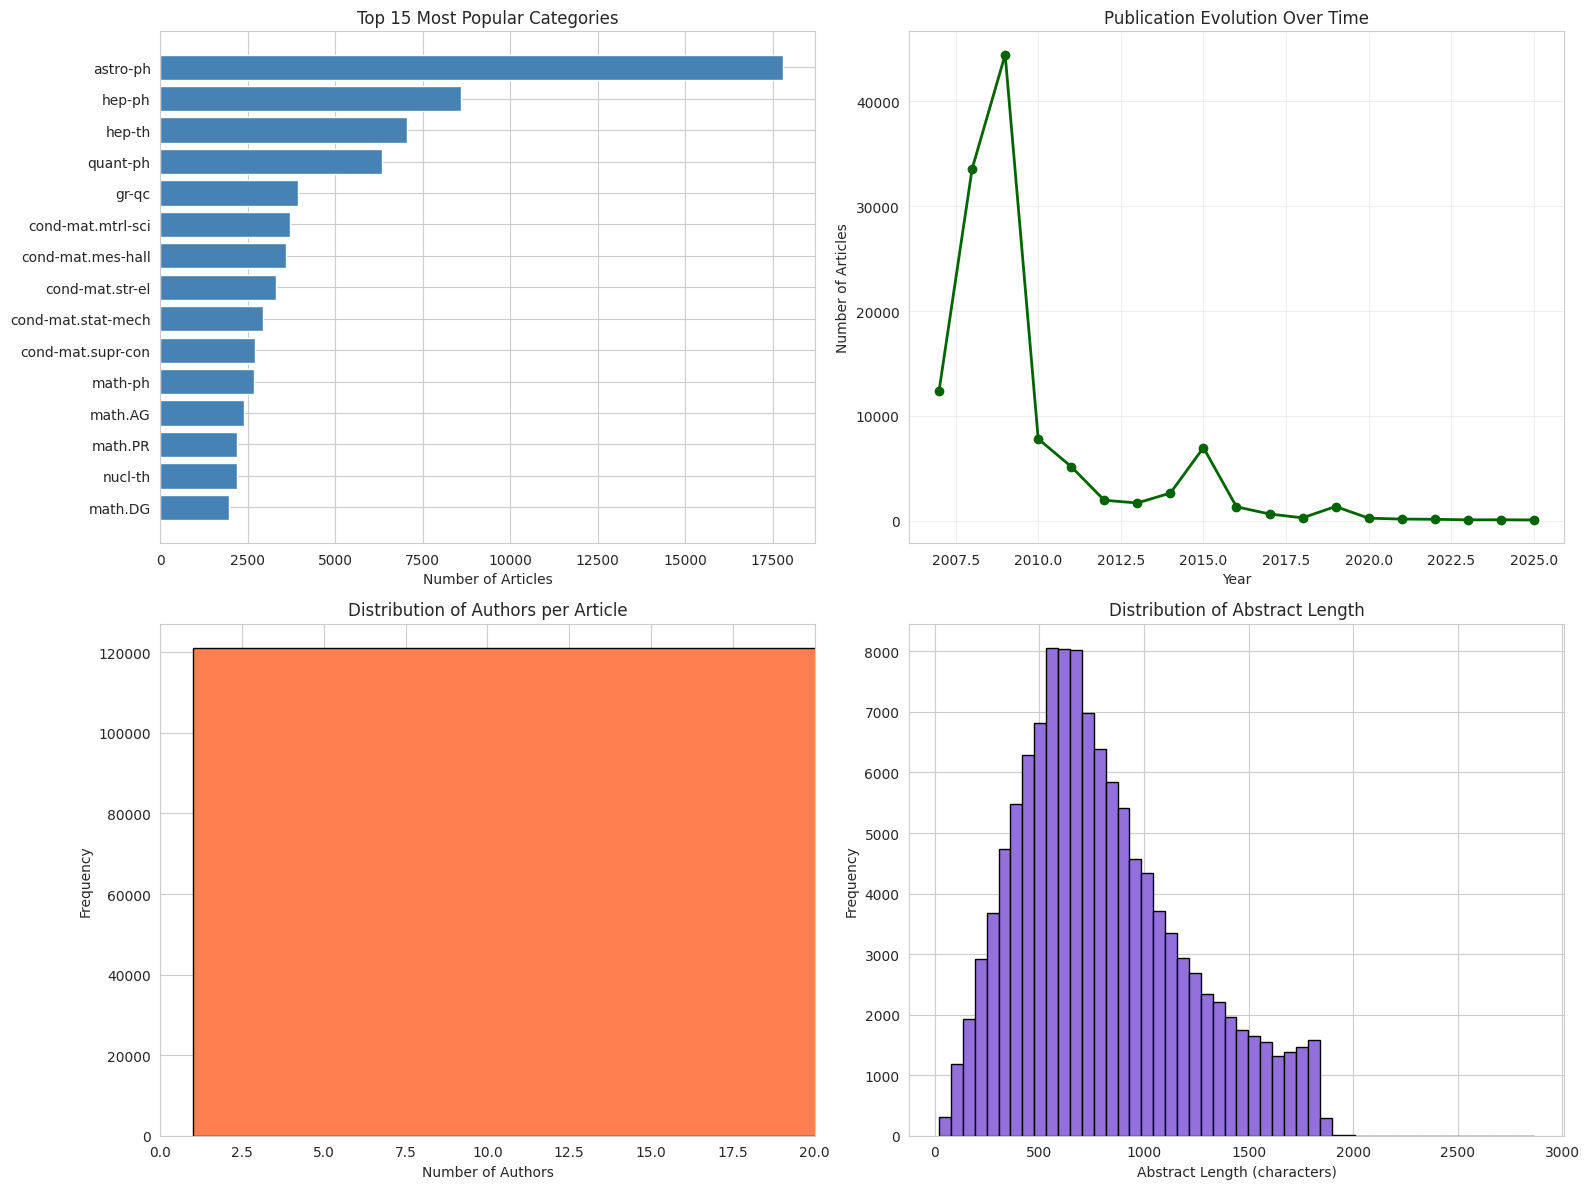

In [16]:
print("\n" + "="*60)
print("GENERATING VISUALIZATIONS...")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

top_cats = df['primary_category'].value_counts().head(15)
axes[0, 0].barh(range(len(top_cats)), top_cats.values, color='steelblue')
axes[0, 0].set_yticks(range(len(top_cats)))
axes[0, 0].set_yticklabels(top_cats.index)
axes[0, 0].set_xlabel('Number of Articles')
axes[0, 0].set_title('Top 15 Most Popular Categories')
axes[0, 0].invert_yaxis()

yearly_counts = df['year'].value_counts().sort_index()
axes[0, 1].plot(yearly_counts.index, yearly_counts.values, marker='o', linewidth=2, color='darkgreen')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Number of Articles')
axes[0, 1].set_title('Publication Evolution Over Time')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].hist(df['num_authors'].dropna(), bins=50, color='coral', edgecolor='black')
axes[1, 0].set_xlabel('Number of Authors')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Authors per Article')
axes[1, 0].set_xlim(0, 20)

axes[1, 1].hist(df['abstract_length'].dropna(), bins=50, color='mediumpurple', edgecolor='black')
axes[1, 1].set_xlabel('Abstract Length (characters)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Abstract Length')

plt.tight_layout()
plt.savefig('arxiv_initial_exploration.png', dpi=300, bbox_inches='tight')
print("Visualizations saved to 'arxiv_initial_exploration.png'")
plt.show()

In [17]:
df.to_pickle('arxiv_sample_processed.pkl')
print("Processed dataset saved to 'arxiv_sample_processed.pkl'")

Processed dataset saved to 'arxiv_sample_processed.pkl'


In [18]:
from collections import Counter

counter = Counter()

with open("arxiv-metadata-oai-snapshot.json", "r") as f:
    for line in f:
        paper = json.loads(line)
        if "categories" in paper:
            counter[paper["categories"].split()[0]] += 1

top_categories = {k for k, _ in counter.most_common(20)}

print(f"\nTop 20 most popular categories:", top_categories)
print("\n" + "="*60)


JSONDecodeError: Unterminated string starting at: line 1 column 159 (char 158)

In [57]:
MAX_PER_CATEGORY = 1000
data = []
counts = defaultdict(int)

with open("arxiv-metadata-oai-snapshot.json", "r") as f:
    for line in f:
        paper = json.loads(line)
        label = paper["categories"].split()[0]

        if label in top_categories and counts[label] < MAX_PER_CATEGORY:
            data.append(paper)
            counts[label] += 1


In [19]:
df = pd.DataFrame(data)
# print(df.head(10))
print(df["categories"])

0                                  hep-ph
1                           math.CO cs.CG
2                          physics.gen-ph
3                                 math.CO
4                         math.CA math.FA
                       ...               
121217                  gr-qc astro-ph.HE
121218            math-ph math.MP math.SP
121219                    cond-mat.str-el
121220                              gr-qc
121221    physics.ins-det physics.comp-ph
Name: categories, Length: 121222, dtype: object


In [20]:
CATEGORY_FULL_NAME = {
    "math.PR": "Mathematics - Probability",
    "quant-ph": "Quantum Physics",
    "math.AG": "Mathematics - Algebraic Geometry",
    "cs.CV": "Computer Science - Computer Vision",
    "cond-mat.mtrl-sci": "Condensed Matter - Materials Science",
    "cond-mat.mes-hall": "Condensed Matter - Mesoscale and Nanoscale Physics",
    "astro-ph.CO": "Astrophysics - Cosmology",
    "math.CO": "Mathematics - Combinatorics",
    "hep-ph": "High Energy Physics - Phenomenology",
    "cond-mat.str-el": "Condensed Matter - Strongly Correlated Electrons",
    "hep-th": "High Energy Physics - Theory",
    "cs.LG": "Computer Science - Machine Learning",
    "astro-ph": "Astrophysics",
    "gr-qc": "General Relativity and Quantum Cosmology",
    "cond-mat.stat-mech": "Condensed Matter - Statistical Mechanics",
    "astro-ph.GA": "Astrophysics - Galaxy Astrophysics",
    "astro-ph.SR": "Astrophysics - Solar and Stellar Astrophysics",
    "cs.CL": "Computer Science - Computation and Language",
    "math.AP": "Mathematics - Analysis of PDEs",
    "astro-ph.HE": "Astrophysics - High Energy Astrophysics"
}

In [24]:
def map_full_names(categories_str):
    codes = categories_str.split(" ")
    mapped = [CATEGORY_FULL_NAME.get(code.strip(), code.strip()) for code in codes]
    return mapped

df["full_names_list"] = df["categories"].apply(map_full_names)
df["label"] = df["full_names_list"].apply(lambda x: x[0] if len(x) > 0 else "Unknown")
print(df[["label"]].value_counts().head(20))
print(df[["label"]])


label                                             
Astrophysics                                          17812
High Energy Physics - Phenomenology                    8593
High Energy Physics - Theory                           7037
Quantum Physics                                        6330
General Relativity and Quantum Cosmology               3933
Condensed Matter - Materials Science                   3708
Condensed Matter - Mesoscale and Nanoscale Physics     3590
Condensed Matter - Strongly Correlated Electrons       3314
Condensed Matter - Statistical Mechanics               2926
cond-mat.supr-con                                      2714
math-ph                                                2667
Mathematics - Algebraic Geometry                       2386
Mathematics - Probability                              2203
nucl-th                                                2199
math.DG                                                1974
hep-ex                                           

In [25]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\$.*?\$", " ", text)
    text = re.sub(r"\\[a-zA-Z]+", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

df["clean_abstract"] = df["abstract"].fillna("").apply(clean_text)


In [22]:
from sklearn.model_selection import train_test_split

X = df["clean_abstract"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))


KeyError: 'label'

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000,
        ngram_range=(1, 2),
        stop_words="english",
        min_df=5
    )),
    ("clf", LogisticRegression(
        max_iter=1000,
        n_jobs=-1
    ))
])

pipeline


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


In [65]:
pipeline.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


In [66]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

                                                    precision    recall  f1-score   support

                                      Astrophysics       0.38      0.18      0.25       200
                          Astrophysics - Cosmology       0.64      0.66      0.65       200
                Astrophysics - Galaxy Astrophysics       0.56      0.59      0.58       200
           Astrophysics - High Energy Astrophysics       0.65      0.71      0.68       200
     Astrophysics - Solar and Stellar Astrophysics       0.62      0.72      0.67       200
       Computer Science - Computation and Language       0.94      0.94      0.94       200
                Computer Science - Computer Vision       0.90      0.85      0.87       200
               Computer Science - Machine Learning       0.86      0.89      0.87       200
              Condensed Matter - Materials Science       0.77      0.78      0.77       200
Condensed Matter - Mesoscale and Nanoscale Physics       0.76      0.74      0.

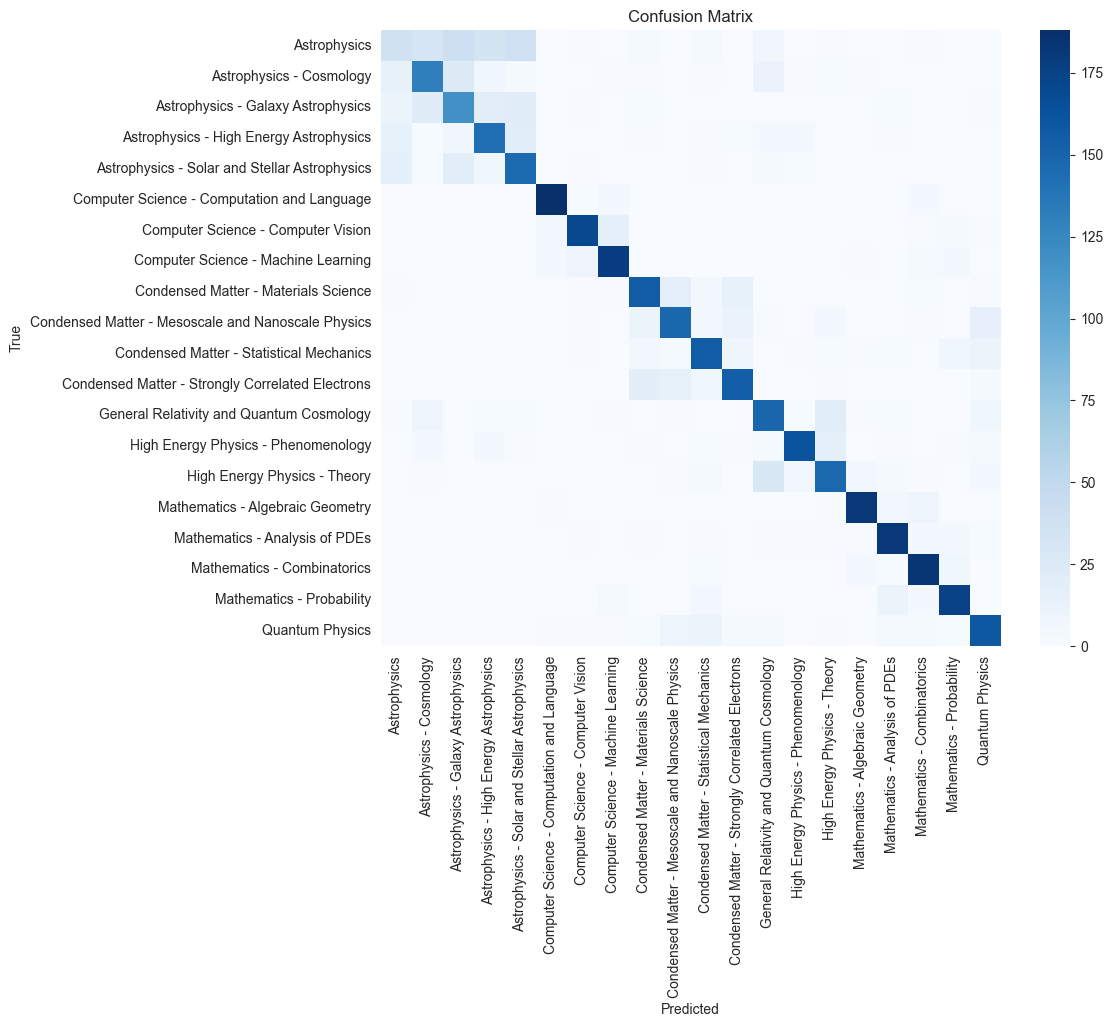

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = sorted(y.unique())

cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [69]:
test_abstract = """
We study a neural network architecture for solving partial differential
equations arising in fluid dynamics.
"""

print(pipeline.predict([clean_text(test_abstract)]))

['Mathematics - Analysis of PDEs']


In [26]:
print(df.columns)

Index(['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi',
       'report-no', 'categories', 'license', 'abstract', 'versions',
       'update_date', 'authors_parsed', 'clean_abstract', 'full_names_list',
       'label'],
      dtype='object')


In [27]:
df_clean = df[["clean_abstract", "label"]]

In [28]:
df_clean.to_csv("your_cleaned_dataframe.csv", index=False)

In [31]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, HashingTF, IDF, Tokenizer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

spark = SparkSession.builder.appName("Arxiv_Abstract_Classifier").getOrCreate()

df = spark.read.csv("file:///home/ubuntu/jupyter/your_cleaned_dataframe.csv", header=True, inferSchema=True)

indexer = StringIndexer(inputCol="label", outputCol="labelIndex")
df = indexer.fit(df).transform(df)

tokenizer = Tokenizer(inputCol="clean_abstract", outputCol="words")
df = tokenizer.transform(df)

hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=10000)
df = hashingTF.transform(df)

idf_model = IDF(inputCol="rawFeatures", outputCol="features").fit(df)
df = idf_model.transform(df)

train, test = df.randomSplit([0.8, 0.2], seed=42)

rf = RandomForestClassifier(labelCol="labelIndex", featuresCol="features", numTrees=50)
model = rf.fit(train)

predictions = model.transform(test)

evaluator = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(accuracy)

spark.stop()


26/01/08 15:45:33 WARN TaskSetManager: Lost task 0.0 in stage 0.0 (TID 0) (172.16.31.119 executor 0): org.apache.spark.SparkFileNotFoundException: File file:/home/ubuntu/jupyter/your_cleaned_dataframe.csv does not exist
It is possible the underlying files have been updated. You can explicitly invalidate the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by recreating the Dataset/DataFrame involved.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.readCurrentFileNotFoundError(QueryExecutionErrors.scala:780)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:220)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:279)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:129)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql

Py4JJavaError: An error occurred while calling o54.csv.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 0.0 failed 4 times, most recent failure: Lost task 0.3 in stage 0.0 (TID 3) (172.16.30.3 executor 1): org.apache.spark.SparkFileNotFoundException: File file:/home/ubuntu/jupyter/your_cleaned_dataframe.csv does not exist
It is possible the underlying files have been updated. You can explicitly invalidate the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by recreating the Dataset/DataFrame involved.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.readCurrentFileNotFoundError(QueryExecutionErrors.scala:780)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:220)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:279)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:129)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:890)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:890)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:530)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:483)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:61)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:4344)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:3326)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4334)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4332)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4332)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:3326)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:3549)
	at org.apache.spark.sql.execution.datasources.csv.TextInputCSVDataSource$.infer(CSVDataSource.scala:111)
	at org.apache.spark.sql.execution.datasources.csv.CSVDataSource.inferSchema(CSVDataSource.scala:64)
	at org.apache.spark.sql.execution.datasources.csv.CSVFileFormat.inferSchema(CSVFileFormat.scala:62)
	at org.apache.spark.sql.execution.datasources.DataSource.$anonfun$getOrInferFileFormatSchema$11(DataSource.scala:208)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.sql.execution.datasources.DataSource.getOrInferFileFormatSchema(DataSource.scala:205)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:407)
	at org.apache.spark.sql.DataFrameReader.loadV1Source(DataFrameReader.scala:229)
	at org.apache.spark.sql.DataFrameReader.$anonfun$load$2(DataFrameReader.scala:211)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:211)
	at org.apache.spark.sql.DataFrameReader.csv(DataFrameReader.scala:538)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkFileNotFoundException: File file:/home/ubuntu/jupyter/your_cleaned_dataframe.csv does not exist
It is possible the underlying files have been updated. You can explicitly invalidate the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by recreating the Dataset/DataFrame involved.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.readCurrentFileNotFoundError(QueryExecutionErrors.scala:780)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:220)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:279)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:129)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:890)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:890)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


In [88]:
# !pip install transformers datasets scikit-learn torch

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch

df = pd.read_csv("your_cleaned_dataframe.csv")

# Encode labels
le = LabelEncoder()
df["label_id"] = le.fit_transform(df["label"])

# Train/test split
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df["label_id"]
)

# Convert to Hugging Face dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

def tokenize(batch):
    return tokenizer(batch["clean_abstract"], padding="max_length", truncation=True, max_length=256)


train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# Set format for PyTorch
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label_id"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label_id"])

num_labels = len(le.classes_)
model = AutoModelForSequenceClassification.from_pretrained(
    "allenai/scibert_scivocab_uncased",
    num_labels=num_labels
)

training_args = TrainingArguments(
    output_dir="./scibert_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
    save_total_limit=2,
    metric_for_best_model="accuracy"
)

import numpy as np
from sklearn.metrics import accuracy_score, f1_score


def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

results = trainer.evaluate()
print(results)

model.save_pretrained("./scibert_model")
tokenizer.save_pretrained("./scibert_model")
import joblib

joblib.dump(le, "./scibert_model/label_encoder.pkl")


Map: 100%|██████████| 4000/4000 [00:07<00:00, 568.06 examples/s] 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'